In [60]:
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


In [61]:
precipitations = pd.read_csv('/mnt/waterchallenge/MainData/00_all_ClimateIndices_and_precip.csv')
# climateIndicesPrecip = pd.read_csv('/mnt/waterchallenge/MainData/00_all_ClimateIndices_and_precip.xlsx')

In [62]:
def get_indices_entire_sequence(
    data: pd.DataFrame, 
    window_size: int, 
    step_size: int
    ) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            data (pd.DataFrame): Partitioned data set, e.g. training data
            
            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

def get_xgboost_x_y(
    indices: list, 
    data: np.array,
    target_sequence_length,
    input_seq_len: int
    ) -> Tuple[np.array, np.array]:

    """
    Args:
        indices: List of index positions at which data should be sliced
        data: A univariate time series
        target_sequence_length: The forecasting horizon, m
        input_seq_len: The length of the model input, n
    Output: 
        all_x: np.array of shape (number of instances, input seq len)
        all_y: np.array of shape (number of instances, target seq len)
    """
    print("Preparing data..")

    # Loop over list of training indices
    for i, idx in enumerate(indices):

        # Slice data into instance of length input length + target length
        data_instance = data[idx[0]:idx[1]]

        x = data_instance[0:input_seq_len]

        assert len(x) == input_seq_len

        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y

In [63]:
precipitations.head()

,date,CAR_ersst,NTA_ersst,aao,ammsst,amon_sm,amon_sm_long,amon_us,amon_us_long,ao,...,soi,solar,swmonsoon,tna,tni,trend,tsa,whwp,wp,precipitation
0,1948-01-01,NaN,NaN,NaN,0.66,0.101,0.101,-0.021,-0.021,NaN,...,NaN,1557.0,0.38,0.16,0.454,1.0,-0.22,-0.17,NaN,108.1699
1,1948-02-01,NaN,NaN,NaN,0.00,0.102,0.102,-0.033,-0.033,NaN,...,NaN,1343.0,1.60,-0.01,0.047,2.0,-0.12,-0.18,NaN,52.6629
2,1948-03-01,NaN,NaN,NaN,1.00,0.102,0.102,0.023,0.023,NaN,...,NaN,1355.0,1.12,0.25,-0.135,3.0,0.04,0.26,NaN,150.4337
3,1948-04-01,NaN,NaN,NaN,1.86,0.106,0.106,-0.075,-0.075,NaN,...,NaN,2081.0,0.26,-0.13,-0.469,4.0,-0.21,-0.03,NaN,222.6304
4,1948-05-01,NaN,NaN,NaN,1.30,0.110,0.110,-0.009,-0.009,NaN,...,NaN,2265.0,0.86,-0.07,-0.950,5.0,-0.40,-0.46,NaN,72.5689


In [64]:
# Preprocessing
# Drop all data that doesn't go past 2016
drop_vars = ["atltri", "brazilrain", "censo_long", "eofpac", "indiamon", "ipotpi_hadisst2", "noi", "swmonsoon", "trend", "epo"]
for var in drop_vars:
    precipitations = precipitations.drop(var, axis=1)

# Drop all data before 1980
precipitations = precipitations[precipitations['date'] > '1980-01-01']

In [65]:
nan_count = precipitations.isna().sum()
print(nan_count)

date              0
CAR_ersst        10
NTA_ersst        10
aao               0
ammsst            0
amon_sm          39
amon_sm_long     39
amon_us           0
amon_us_long      0
ao                0
censo             0
ea                0
espi              0
gmsst             0
hurr             48
jonesnao          0
meiv2             0
nao               0
nina1_anom        0
nina34_anom       0
nina3_anom        0
nina4_anom        0
np                6
oni               0
pdo               0
pna               0
qbo               0
sahelrain        36
soi               0
solar             0
tna               0
tni               0
tsa               0
whwp              0
wp                0
precipitation     0
dtype: int64


In [66]:
selected_features = \
    ['CAR_ersst',
    'NTA_ersst',
    'aao',
    'ammsst',
    'amon_sm',
    'amon_sm_long',
    'amon_us',
    'amon_us_long',
    'ao',
    'censo',
    'ea',
    'espi',
    'gmsst',
    'hurr',
    'jonesnao',
    'meiv2',
    'nao',
    'nina1_anom',
    'nina34_anom',
    'nina3_anom',
    'nina4_anom',
    'np',
    'oni',
    'pdo',
    'pna',
    'qbo',
    'sahelrain',
    'soi',
    'solar',
    'tna',
    'tni',
    'tsa',
    'whwp',
    'wp',
    'precipitation']

# hyperparameters
hyperparameters = {
    "in_length" : 24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : selected_features
    }


In [67]:
# Extract features & labels
X = precipitations.iloc[:,1:-1].values
y = precipitations.iloc[:, -1].values
# Create train & test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size = 0.12, \
                         random_state = 0, shuffle=False)

X_test

array([[ 0.55 ,  0.34 ,  1.093, ...,  0.59 ,  1.41 ,  1.61 ],
       [ 0.55 ,  0.25 ,  2.038, ...,  0.6  ,  4.04 , -0.2  ],
       [ 0.62 ,  0.24 ,  0.097, ...,  0.39 ,  2.53 , -0.26 ],
       ...,
       [   nan,    nan,  1.264, ...,  0.39 ,  4.49 , -1.18 ],
       [   nan,    nan,  0.813, ...,  0.12 ,  2.34 ,  0.72 ],
       [   nan,    nan,  1.481, ..., -0.11 ,  0.15 ,  0.99 ]])

In [68]:
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

model = xgb.XGBRegressor()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

# trained_model = MultiOutputRegressor(model).fit(x_train, y_train)


trained_model = model.fit(X_train_scaled, y_train)
# trained_model.get_booster().get_score(importance_type='gain')
# test_forecasts = trained_model.predict(x_test)


(432, 34)


In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# Quickly plot and show prediction vs actual data
def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.xlabel("Months since Jan 1st, 2012")
    plt.ylabel("Precipitation (inches)")
    plt.show()
    print("RSME: " + str((y, predictions)))
    return df, mse(y, predictions)

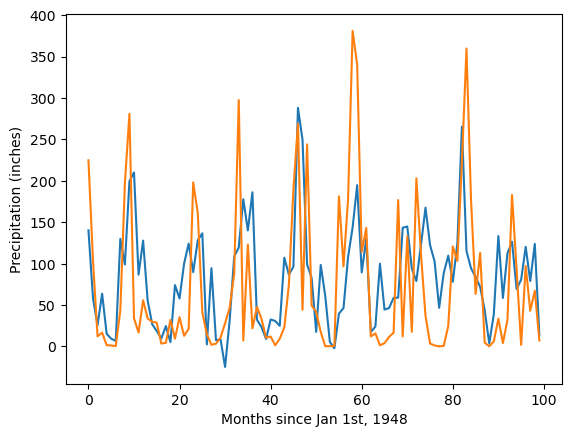

RSME: (array([2.247578e+02, 1.031797e+02, 1.230380e+01, 1.664520e+01,
       1.607600e+00, 1.208400e+00, 5.175000e-01, 4.385870e+01,
       1.968465e+02, 2.808822e+02, 3.401430e+01, 1.688400e+01,
       5.580450e+01, 3.377250e+01, 2.977070e+01, 2.879770e+01,
       3.515800e+00, 4.506000e+00, 3.207140e+01, 9.500800e+00,
       3.539420e+01, 1.292920e+01, 2.119960e+01, 1.980503e+02,
       1.613026e+02, 4.125070e+01, 1.449350e+01, 2.089800e+00,
       3.341000e+00, 1.078540e+01, 2.804060e+01, 4.691960e+01,
       8.796250e+01, 2.974748e+02, 7.089200e+00, 1.230254e+02,
       2.186030e+01, 4.771840e+01, 3.318800e+01, 1.055140e+01,
       1.202410e+01, 1.459500e+00, 9.270500e+00, 2.298310e+01,
       7.406550e+01, 1.895778e+02, 2.687216e+02, 4.430110e+01,
       2.440325e+02, 4.935290e+01, 4.193100e+01, 1.746520e+01,
       3.426000e-01, 4.173000e-01, 7.685000e-01, 1.812137e+02,
       9.667020e+01, 1.776215e+02, 3.809620e+02, 3.402068e+02,
       1.141328e+02, 1.431149e+02, 1.218760e+01,

(     Predictions   Actuals
 0     140.290070  224.7578
 1      58.323395  103.1797
 2      25.798544   12.3038
 3      63.771408   16.6452
 4      15.312619    1.6076
 ..           ...       ...
 101   101.661057    3.2309
 102    97.715240    0.1364
 103   285.778351    0.8095
 104   141.032394   55.8867
 105   130.230301   73.7052
 
 [106 rows x 2 columns],
 7413.179655857428)

In [91]:
precipitations.isna()
plot_predictions1(trained_model, X_test_scaled, y_test)

{0: 'CAR_ersst', 1: 'NTA_ersst', 2: 'aao', 3: 'ammsst', 4: 'amon_sm', 5: 'amon_sm_long', 6: 'amon_us', 7: 'amon_us_long', 8: 'ao', 9: 'censo', 10: 'ea', 11: 'espi', 12: 'gmsst', 13: 'hurr', 14: 'jonesnao', 15: 'meiv2', 16: 'nao', 17: 'nina1_anom', 18: 'nina34_anom', 19: 'nina3_anom', 20: 'nina4_anom', 21: 'np', 22: 'oni', 23: 'pdo', 24: 'pna', 25: 'qbo', 26: 'sahelrain', 27: 'soi', 28: 'solar', 29: 'tna', 30: 'tni', 31: 'tsa', 32: 'whwp', 33: 'wp', 34: 'precipitation'}


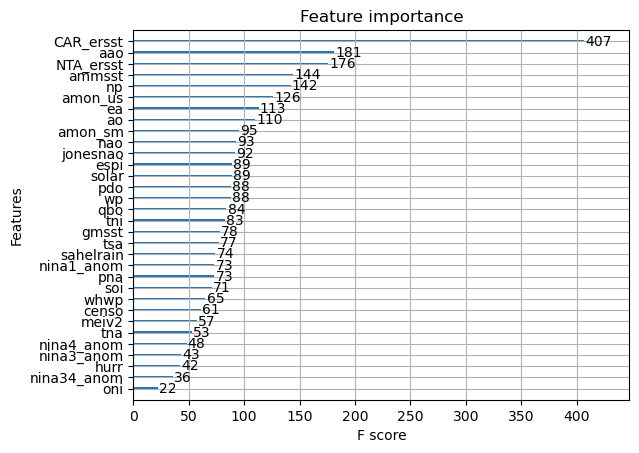

In [71]:
# create dict to use later
dict_features = dict(enumerate(selected_features))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(trained_model)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(selected_features))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
print(dict_features)
plt.show()

In [72]:
selected_features = \
    [
        "date",
        "hurr_l5",
        "np_l7",
        "precip_l12",
        "NTA_ersst",
        "ao",
        "censo",
        "hurr",
        "np",
        "sahelrain",
        "soi",
        "whwp",
        "precipitation"
    ]

# hyperparameters
hyperparameters = {
    "in_length" : 24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : selected_features
    }



In [73]:
hurr_lags = pd.read_csv("/home/zeusboost/dev/lags/hurr.csv")
np_lags = pd.read_csv("/home/zeusboost/dev/lags/np.csv")
precip_lags = pd.read_csv("/home/zeusboost/dev/lags/precipitation.csv")
precipitations = pd.read_csv("/mnt/waterchallenge/MainData/00_all_ClimateIndices_and_precip.csv")

In [74]:
precipitations

,date,CAR_ersst,NTA_ersst,aao,ammsst,amon_sm,amon_sm_long,amon_us,amon_us_long,ao,...,soi,solar,swmonsoon,tna,tni,trend,tsa,whwp,wp,precipitation
0,1948-01-01,NaN,NaN,NaN,0.66,0.101,0.101,-0.021,-0.021,NaN,...,NaN,1557.0,0.38,0.16,0.454,1.0,-0.22,-0.17,NaN,108.1699
1,1948-02-01,NaN,NaN,NaN,0.00,0.102,0.102,-0.033,-0.033,NaN,...,NaN,1343.0,1.60,-0.01,0.047,2.0,-0.12,-0.18,NaN,52.6629
2,1948-03-01,NaN,NaN,NaN,1.00,0.102,0.102,0.023,0.023,NaN,...,NaN,1355.0,1.12,0.25,-0.135,3.0,0.04,0.26,NaN,150.4337
3,1948-04-01,NaN,NaN,NaN,1.86,0.106,0.106,-0.075,-0.075,NaN,...,NaN,2081.0,0.26,-0.13,-0.469,4.0,-0.21,-0.03,NaN,222.6304
4,1948-05-01,NaN,NaN,NaN,1.30,0.110,0.110,-0.009,-0.009,NaN,...,NaN,2265.0,0.86,-0.07,-0.950,5.0,-0.40,-0.46,NaN,72.5689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,2020-08-01,NaN,NaN,-0.720,0.29,NaN,NaN,0.428,0.428,-0.381,...,1.8,717.0,NaN,0.59,-1.586,NaN,0.50,5.79,-0.21,3.2309
872,2020-09-01,NaN,NaN,0.194,1.90,NaN,NaN,0.299,0.299,0.631,...,1.5,706.0,NaN,0.52,-1.090,NaN,0.24,3.53,-2.44,0.1364
873,2020-10-01,NaN,NaN,1.264,3.77,NaN,NaN,0.291,0.291,-0.072,...,0.8,746.0,NaN,0.61,-0.441,NaN,0.39,4.49,-1.18,0.8095
874,2020-11-01,NaN,NaN,0.813,2.92,NaN,NaN,0.115,0.115,2.086,...,1.1,901.0,NaN,0.39,0.165,NaN,0.12,2.34,0.72,55.8867


In [75]:
### LAGS FEATURE SELECTION
# Extract features & labels

df = pd.DataFrame()
df['date'] = precipitations['date']
df['hurr_l5'] = hurr_lags['t -5']
df['np_l7'] = np_lags['t -7']
df['precip_l12'] = hurr_lags['t -12']
df['NTA_ersst'] = precipitations['NTA_ersst']
df['ao'] = precipitations['ao']
df['censo'] = precipitations['censo']
df['hurr'] = precipitations['hurr']
df['np'] = precipitations['np']
df['sahelrain'] = precipitations['sahelrain']
df['soi'] = precipitations['soi']
df['whwp'] = precipitations['whwp']
df['precipitation'] = precipitations['precipitation']

precipitations = df

# Drop all data before 1980
# precipitations = precipitations[precipitations['date'] > '1980-01-01']


X = precipitations.iloc[:,1:-1].values
y = precipitations.iloc[:, -1].values
# Create train & test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size = 0.12, \
                         random_state = 0, shuffle=False)

In [76]:
df

,date,hurr_l5,np_l7,precip_l12,NTA_ersst,ao,censo,hurr,np,sahelrain,soi,whwp,precipitation
0,1948-01-01,NaN,NaN,NaN,NaN,NaN,0.26,0.0,1009.12,-5.0,NaN,-0.17,108.1699
1,1948-02-01,NaN,NaN,NaN,NaN,NaN,0.43,0.0,1014.00,7.0,NaN,-0.18,52.6629
2,1948-03-01,NaN,NaN,NaN,NaN,NaN,0.72,0.0,1016.66,-6.0,NaN,0.26,150.4337
3,1948-04-01,NaN,NaN,NaN,NaN,NaN,0.21,0.0,1020.68,161.0,NaN,-0.03,222.6304
4,1948-05-01,NaN,NaN,NaN,NaN,NaN,0.24,0.0,1016.02,9.0,NaN,-0.46,72.5689
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,2020-08-01,NaN,1010.16,NaN,NaN,-0.381,-1.28,NaN,NaN,NaN,1.8,5.79,3.2309
872,2020-09-01,NaN,1011.12,NaN,NaN,0.631,-1.24,NaN,NaN,NaN,1.5,3.53,0.1364
873,2020-10-01,NaN,1019.99,NaN,NaN,-0.072,-1.19,NaN,NaN,NaN,0.8,4.49,0.8095
874,2020-11-01,NaN,1014.00,NaN,NaN,2.086,-1.19,NaN,NaN,NaN,1.1,2.34,55.8867


In [77]:
len(y_test)

106

In [78]:
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

model = xgb.XGBRegressor()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

# trained_model = MultiOutputRegressor(model).fit(x_train, y_train)


trained_model = model.fit(X_train_scaled, y_train)
# trained_model.get_booster().get_score(importance_type='gain')
# test_forecasts = trained_model.predict(x_test)


(770, 11)


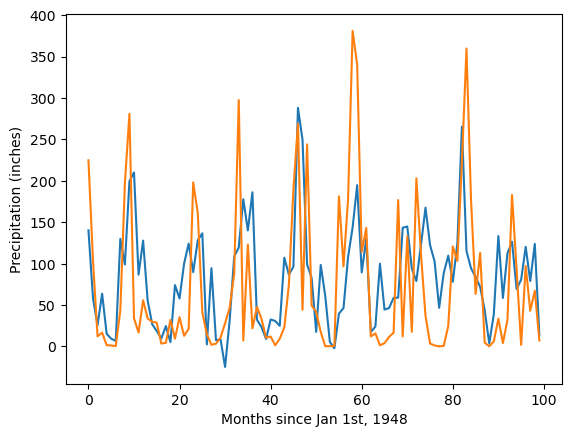

RSME: (array([2.247578e+02, 1.031797e+02, 1.230380e+01, 1.664520e+01,
       1.607600e+00, 1.208400e+00, 5.175000e-01, 4.385870e+01,
       1.968465e+02, 2.808822e+02, 3.401430e+01, 1.688400e+01,
       5.580450e+01, 3.377250e+01, 2.977070e+01, 2.879770e+01,
       3.515800e+00, 4.506000e+00, 3.207140e+01, 9.500800e+00,
       3.539420e+01, 1.292920e+01, 2.119960e+01, 1.980503e+02,
       1.613026e+02, 4.125070e+01, 1.449350e+01, 2.089800e+00,
       3.341000e+00, 1.078540e+01, 2.804060e+01, 4.691960e+01,
       8.796250e+01, 2.974748e+02, 7.089200e+00, 1.230254e+02,
       2.186030e+01, 4.771840e+01, 3.318800e+01, 1.055140e+01,
       1.202410e+01, 1.459500e+00, 9.270500e+00, 2.298310e+01,
       7.406550e+01, 1.895778e+02, 2.687216e+02, 4.430110e+01,
       2.440325e+02, 4.935290e+01, 4.193100e+01, 1.746520e+01,
       3.426000e-01, 4.173000e-01, 7.685000e-01, 1.812137e+02,
       9.667020e+01, 1.776215e+02, 3.809620e+02, 3.402068e+02,
       1.141328e+02, 1.431149e+02, 1.218760e+01,

(     Predictions   Actuals
 0     140.290070  224.7578
 1      58.323395  103.1797
 2      25.798544   12.3038
 3      63.771408   16.6452
 4      15.312619    1.6076
 ..           ...       ...
 101   101.661057    3.2309
 102    97.715240    0.1364
 103   285.778351    0.8095
 104   141.032394   55.8867
 105   130.230301   73.7052
 
 [106 rows x 2 columns],
 7413.179655857428)

In [92]:
plot_predictions1(trained_model, X_test_scaled, y_test)

{0: 'date', 1: 'hurr_l5', 2: 'np_l7', 3: 'precip_l12', 4: 'NTA_ersst', 5: 'ao', 6: 'censo', 7: 'hurr', 8: 'np', 9: 'sahelrain', 10: 'soi', 11: 'whwp', 12: 'precipitation'}


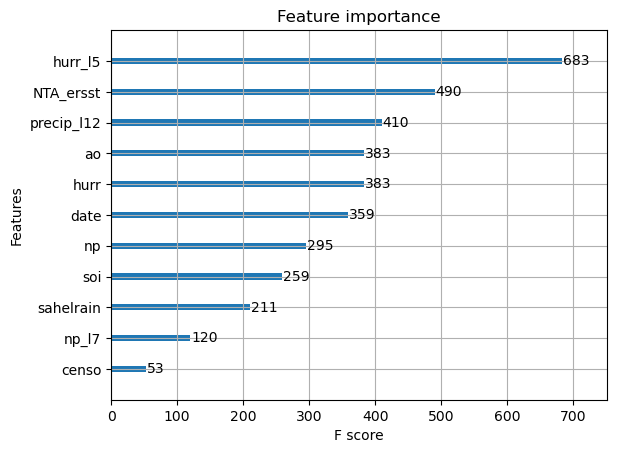

In [80]:
# create dict to use later
dict_features = dict(enumerate(selected_features))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(trained_model)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(selected_features))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
print(dict_features)
plt.show()

In [87]:
predictions = model.predict(X).flatten()
finaldf = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})

finaldf['date'] = df['date']
finaldf.to_csv("predictions.csv", sep=',')